### Import Libraries

In [1]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

### Get Data

In [2]:
api_key = '78f064b56cef41ed48ee76b18d2d456a6ea286bb'
df_paypal = pdr.tiingo.TiingoDailyReader('PYPL', api_key = api_key).read()

In [3]:
dataframes = [df_paypal]
column_names = ['date', 'open']
df_paypal.shape, df_paypal.head(), df_paypal.tail()

((1258, 12),
                                   close    high      low   open    volume  \
 symbol date                                                                 
 PYPL   2017-11-24 00:00:00+00:00  78.57  78.900  77.7000  77.81   4305618   
        2017-11-27 00:00:00+00:00  77.84  79.385  77.7100  78.63   6745449   
        2017-11-28 00:00:00+00:00  77.79  78.230  77.2435  77.95   8570920   
        2017-11-29 00:00:00+00:00  73.25  77.980  71.6700  77.95  25165672   
        2017-11-30 00:00:00+00:00  75.73  75.870  73.5400  73.77  15933501   
 
                                   adjClose  adjHigh   adjLow  adjOpen  \
 symbol date                                                             
 PYPL   2017-11-24 00:00:00+00:00     78.57   78.900  77.7000    77.81   
        2017-11-27 00:00:00+00:00     77.84   79.385  77.7100    78.63   
        2017-11-28 00:00:00+00:00     77.79   78.230  77.2435    77.95   
        2017-11-29 00:00:00+00:00     73.25   77.980  71.6700    77.9

In [4]:
for count, df in enumerate(dataframes):
    df.reset_index(inplace=True)
    df = df[column_names]
    df.to_csv('data' + str(count) + '.csv')

In [5]:
def train_test_split(df, split): #70% train, #30% test
    length = len(df)
    train = round(length * split)
    valid = round(length - train)
    print("Original length: ", length)
    print("Train length: ", train)
    print("Valid length: ", valid)
    train_data = df[:train]
    validation_data = df[train:]
    return train_data, validation_data

In [6]:
def prepare_data(data, time_step): #timestep
    X, y = [], []
    length = len(data)
    # Sliding window
    for i in range(time_step, length):
        X.append(data[i-time_step:i,0])
        y.append(data[i,0])
        
    # Convert to arrays:
    X, y = np.array(X), np.array(y)
    
    # Reshaping
    X = np.reshape(X, (X.shape[0], X.shape[1],1))
    y = np.reshape(y, (y.shape[0],1))
    
    return X, y

### Training

In [7]:
def train(stock_name, stock_data, split, time_step = 50):
    print(f"Training on {stock_name} stock data")
    # Train-Test Split
    train_data, valid_data = train_test_split(stock_data, split)
    
    # Train data and reshape
    X_train = train_data.open.values
    X_train = X_train.reshape(-1, 1) #column vector made
    
    # Scaler
    scaler = MinMaxScaler(feature_range = (0,1)) #defining scaler
    
    # Re-scale
    X_train = scaler.fit_transform(X_train) #scaling
    
    # Plot Stock Data - Training
    plt.subplots(figsize = (15,6))
    plt.plot(scaler.inverse_transform(X_train))
    plt.xlabel("Days")
    plt.ylabel("Open Price")
    plt.title(f'{stock_name} Stock Data (Train)')
    plt.savefig(f'data-{stock_name}.png')
    plt.show()
    
    X_train, y_train = prepare_data(X_train, time_step)
    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    
    # Simple RNN
    simplernn = Sequential(name = f'SimpleRNN-{stock_name}')
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh'))
    simplernn.add(Dropout(0.2))
    simplernn.add(Dense(1))
    plot_model(simplernn, to_file='rnn.png', show_shapes=True)

    # Compiling the model
    simplernn.compile(optimizer = "adam", loss = "mean_squared_error")
    print(simplernn.summary())
    
    # Run the model
    print(f"\nTraining SimpleRNN model on {stock_name} data")
    historysimplernn = simplernn.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 1)
    
    # Loss vs Epoch
    plt.figure(figsize =(10,7))
    plt.plot(historysimplernn.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"Loss vs Epoch (SimpleRNN {stock_name})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Training Data Prediction & Plot
    y_pred = simplernn.predict(X_train)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_train), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"Simple RNN model - {stock_name}, Training Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-rnn.png')
    plt.show()
    
    
    # Validation
    X_test = valid_data.open.values
    X_test = X_test.reshape(-1, 1)
    X_test = scaler.fit_transform(X_test)
    X_test, y_test = prepare_data(X_test, 50)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)
    
    # Test Data Predictions & Plot
    y_test_pred = simplernn.predict(X_test)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_test), color = "b", label = "y_test")
    plt.plot(scaler.inverse_transform(y_test_pred), color = "orange", label = "y_test_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"Simple RNN model - {stock_name}, Test Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-validation-{time_step}-rnn.png')
    plt.show()
    
    
    # RMSE Error
    rnn_rmse_train = mean_squared_error(scaler.inverse_transform(y_train), scaler.inverse_transform(y_pred))
    rnn_rmse_test = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_pred))
    
    # LSTM Define & Train
    lstm = Sequential(name = f'LSTM-{stock_name}')
    lstm.add(LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1)))
    lstm.add(LSTM(64, return_sequences= False))
    lstm.add(Dense(32))
    lstm.add(Dense(1))
    lstm.compile(loss = "mean_squared_error", optimizer = "adam")
    print(lstm.summary())
    print(f"\nTraining LSTM model on {stock_name} data")
    historylstm = lstm.fit(X_train, y_train, epochs=50, batch_size = 32, verbose = 1)
    plot_model(lstm, to_file='model_lstm.png')
    
    # Loss vs Epoch
    plt.figure(figsize =(10,7))
    plt.plot(historylstm.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"Loss vs Epoch (LSTM {stock_name})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Training Data Prediction & Plot
    y_pred = lstm.predict(X_train)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_train), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"LSTM model - {stock_name}, Training Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-lstm.png')
    plt.show()
    
    # Test Data Predictions & Plot
    y_test_pred = lstm.predict(X_test)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_test), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_test_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"LSTM model - {stock_name}, Test Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-lstm.png')
    plt.show()
    
    
    # RMSE Error
    lstm_rmse_train = mean_squared_error(scaler.inverse_transform(y_train), scaler.inverse_transform(y_pred))
    lstm_rmse_test = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_pred))
    
    
    # Saving
    simplernn.save(f'simplernn-{stock_name}-{str(time_step)}.h5')
    lstm.save(f'lstm-{stock_name}-{str(time_step)}.h5')
    return (time_step, rnn_rmse_train, rnn_rmse_test, lstm_rmse_train, lstm_rmse_test)
    

Training on Paypal stock data
Original length:  1258
Train length:  881
Valid length:  377


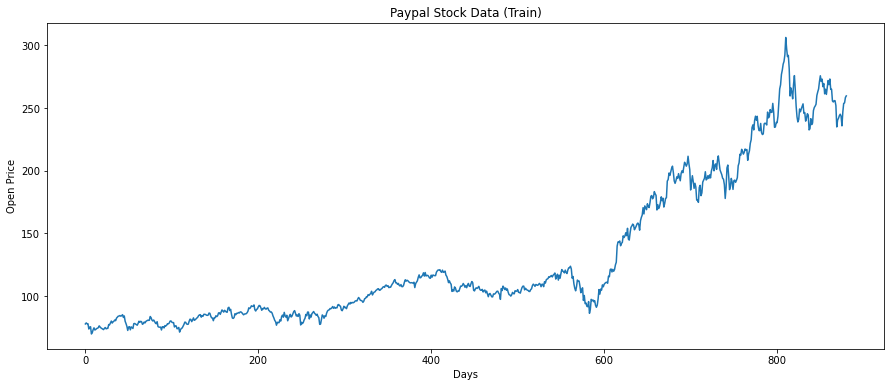

Shape of X_train:  (841, 40, 1)
Shape of y_train:  (841, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 40, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40, 50)            5050      
                                       

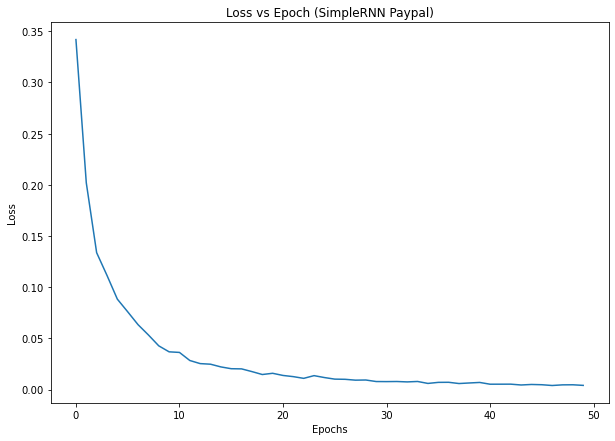

27/27 [==============================] - 1s 7ms/step


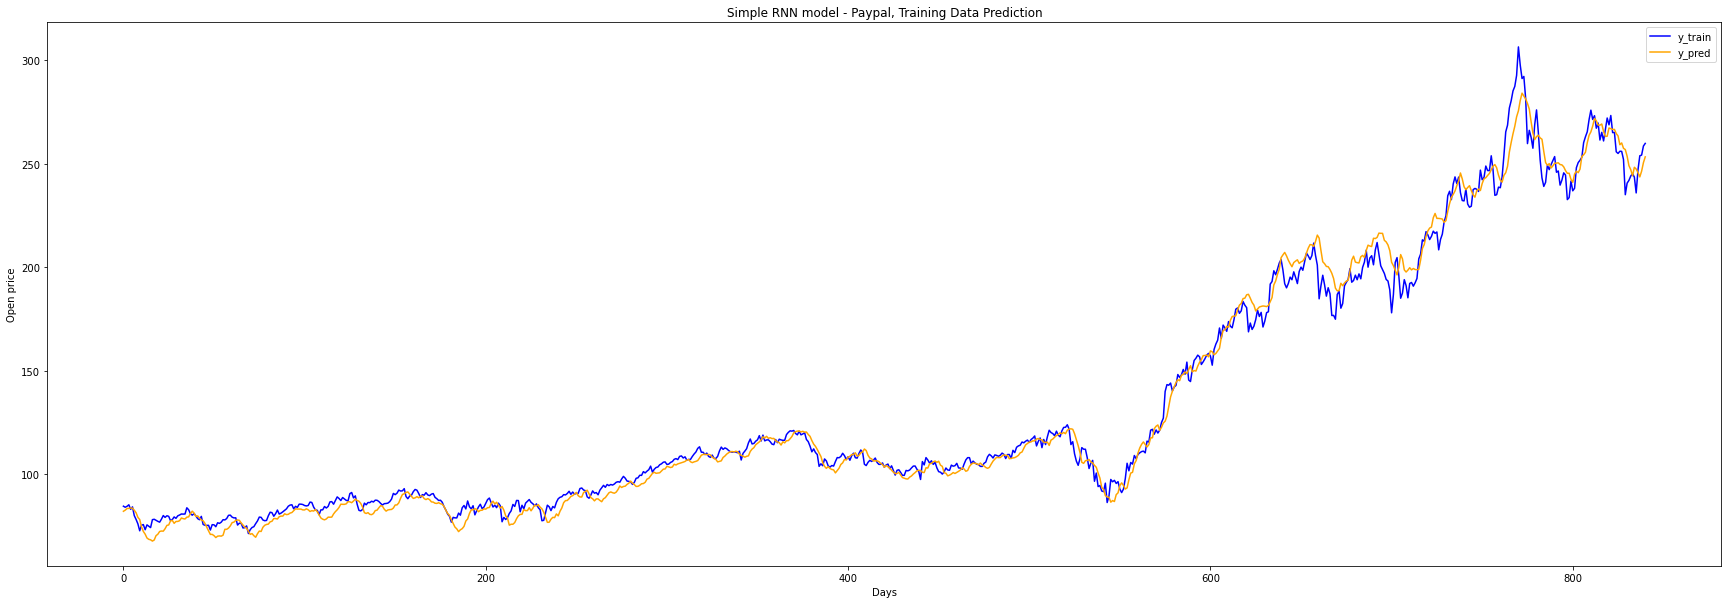

Shape of X_test:  (327, 50, 1)
Shape of y_test:  (327, 1)
11/11 [==============================] - 1s 9ms/step


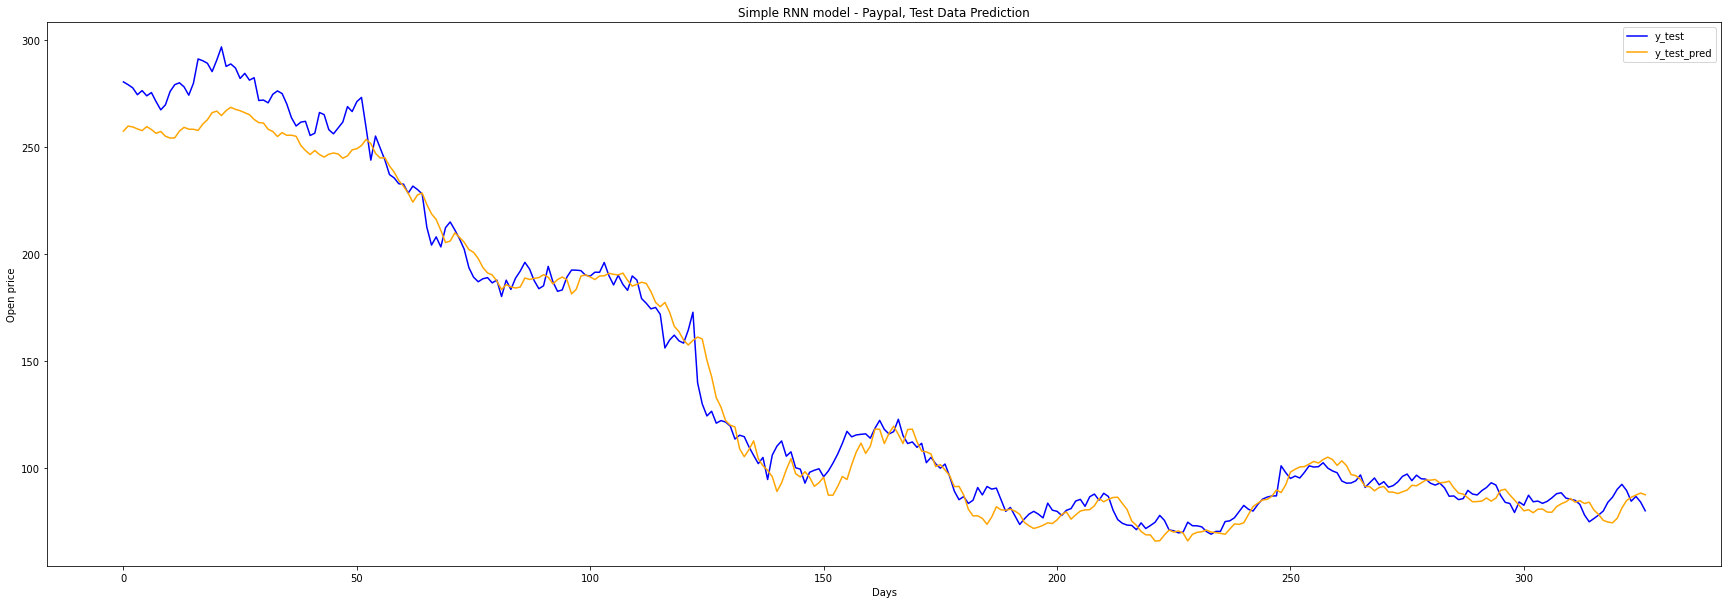

Model: "LSTM-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________
None

Training LSTM model on Paypal data
Epoch 1/50
85/85 [==============================] - 7s 22ms/step - loss: 0.0071
Epoch 2/50
85/85 [==============================] - 2s 22ms/st

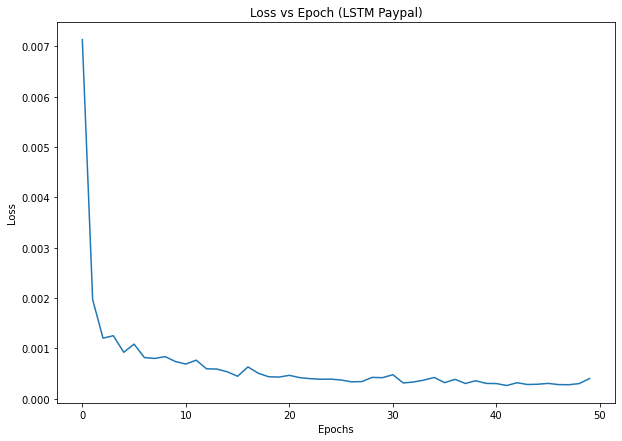

27/27 [==============================] - 2s 13ms/step


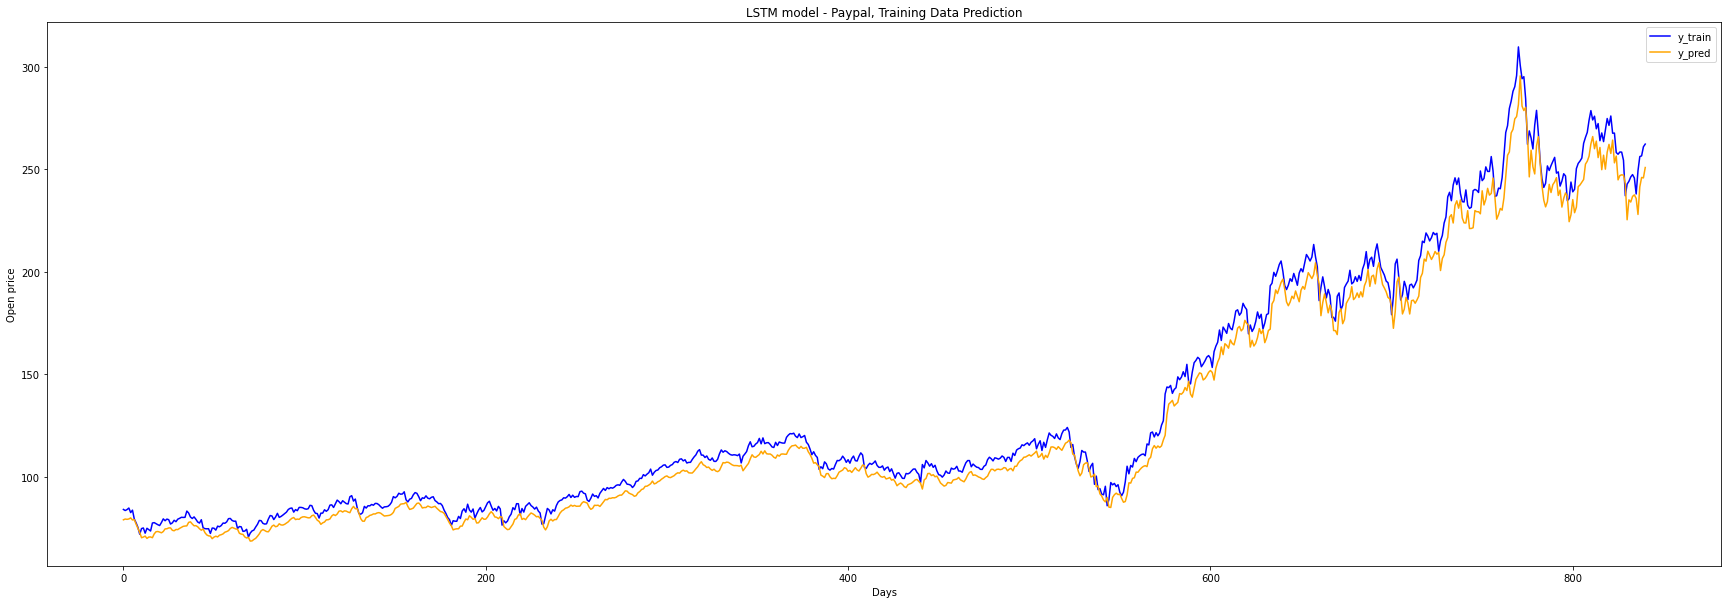

11/11 [==============================] - 2s 11ms/step


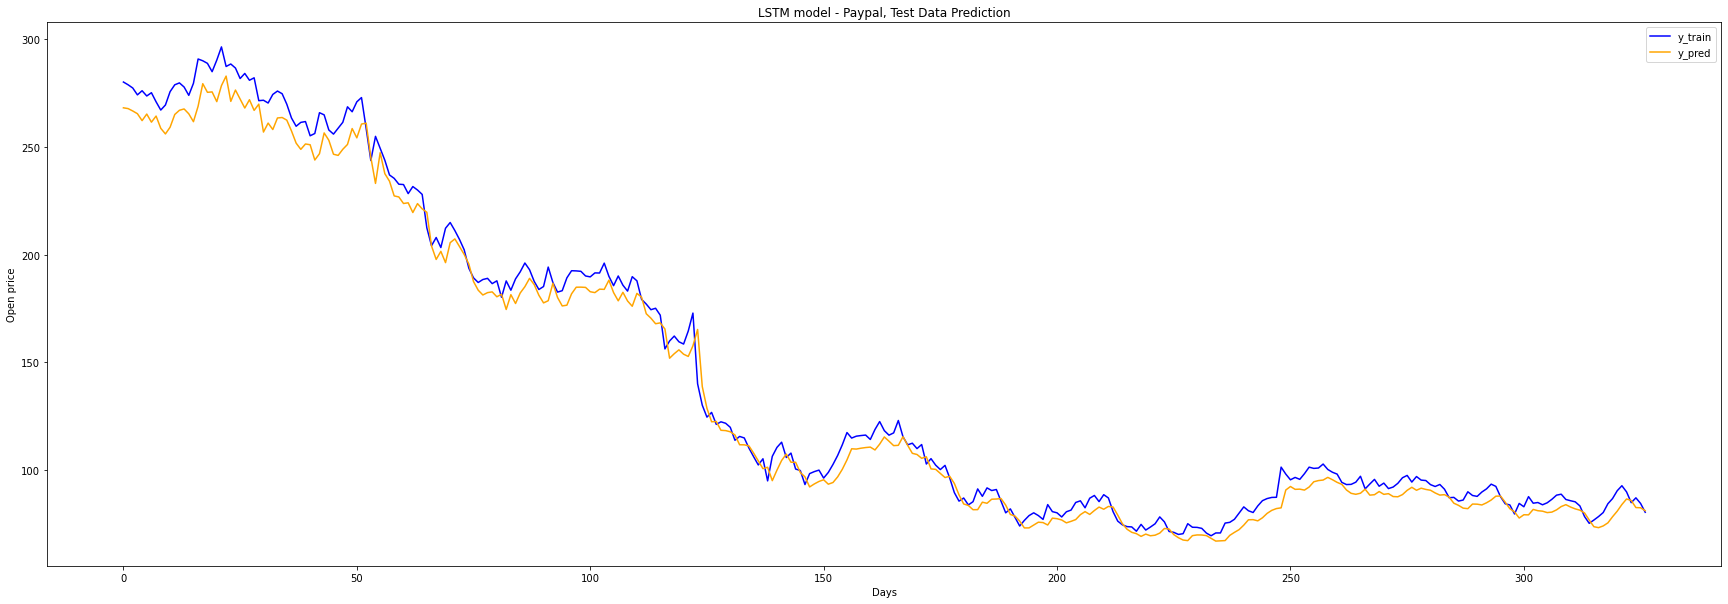

(40, 37.10900801143852, 95.89397524332344, 59.62519590267189, 58.261839189345714)


In [8]:
output = train('Paypal', df_paypal, 0.7, 40)
print(output)

Training on Paypal stock data
Original length:  1258
Train length:  881
Valid length:  377


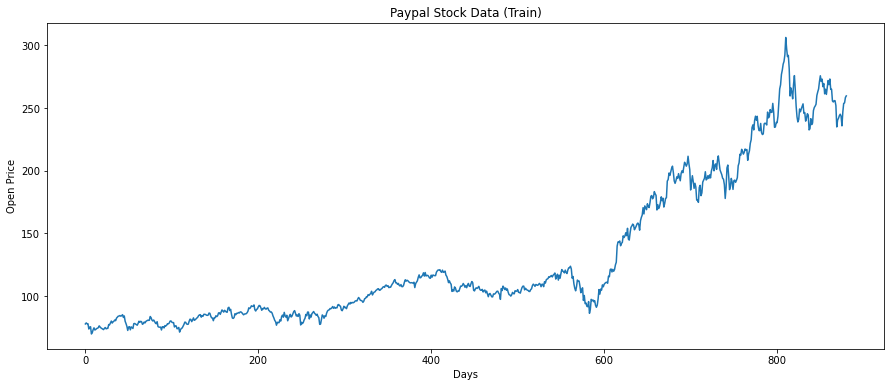

Shape of X_train:  (831, 50, 1)
Shape of y_train:  (831, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                       

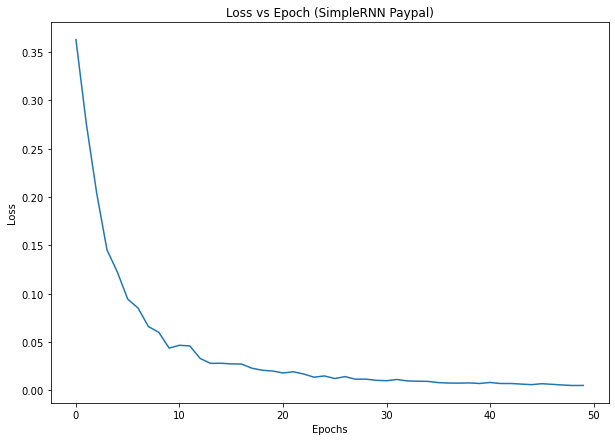

26/26 [==============================] - 2s 13ms/step


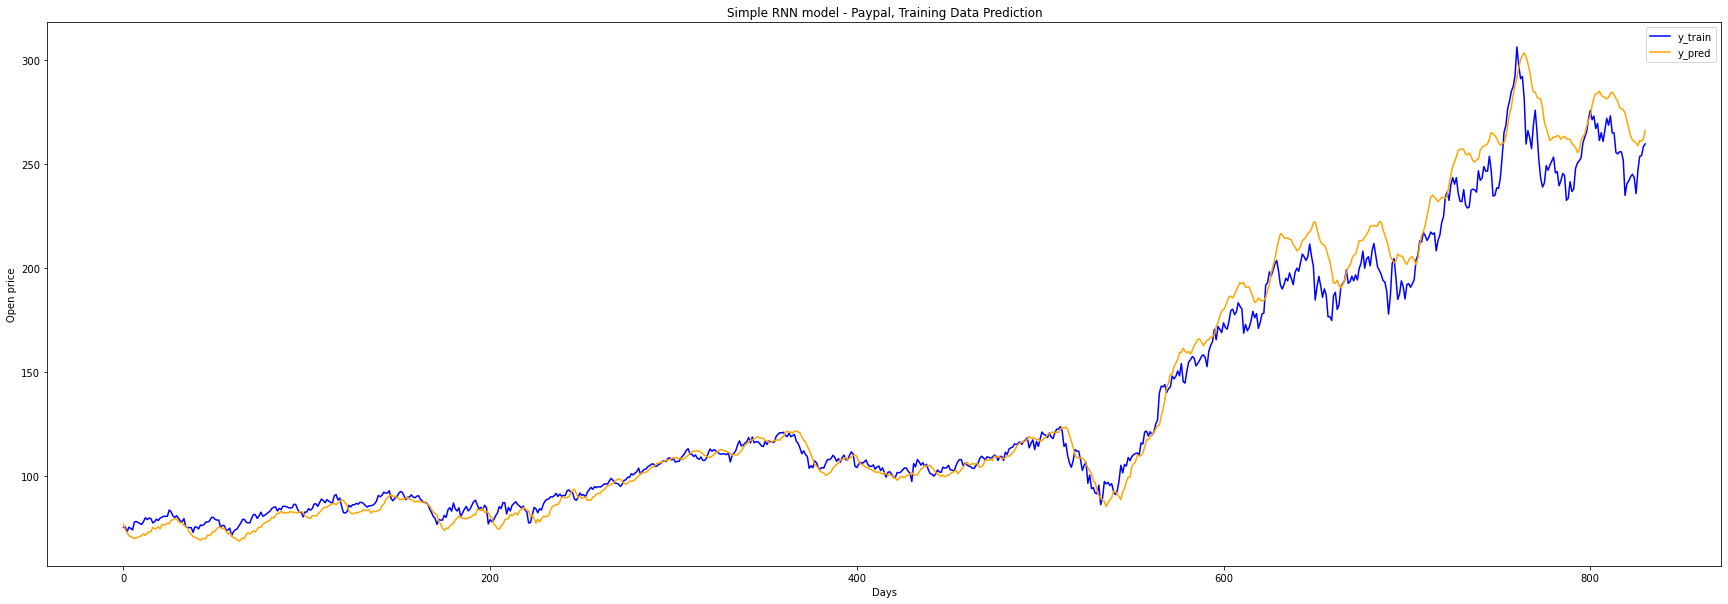

Shape of X_test:  (327, 50, 1)
Shape of y_test:  (327, 1)
11/11 [==============================] - 0s 19ms/step


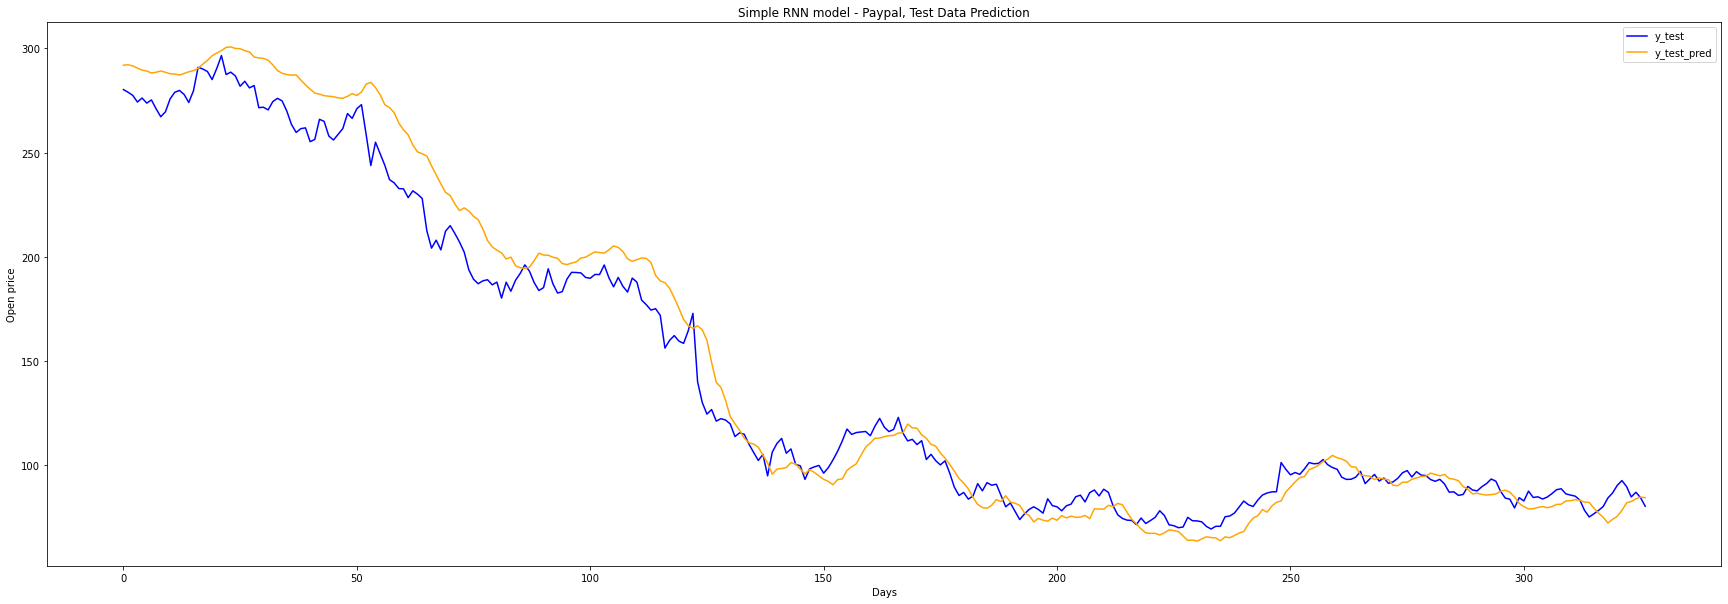

Model: "LSTM-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________
None

Training LSTM model on Paypal data
Epoch 1/50
84/84 [==============================] - 9s 36ms/step - loss: 0.0078
Epoch 2/50
84/84 [==============================] - 3s 40ms/st

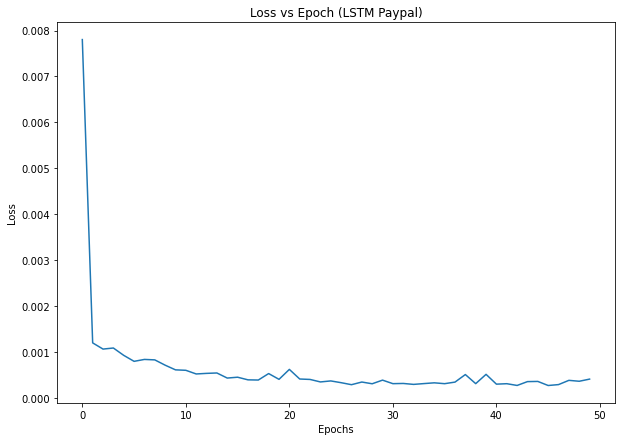

26/26 [==============================] - 2s 12ms/step


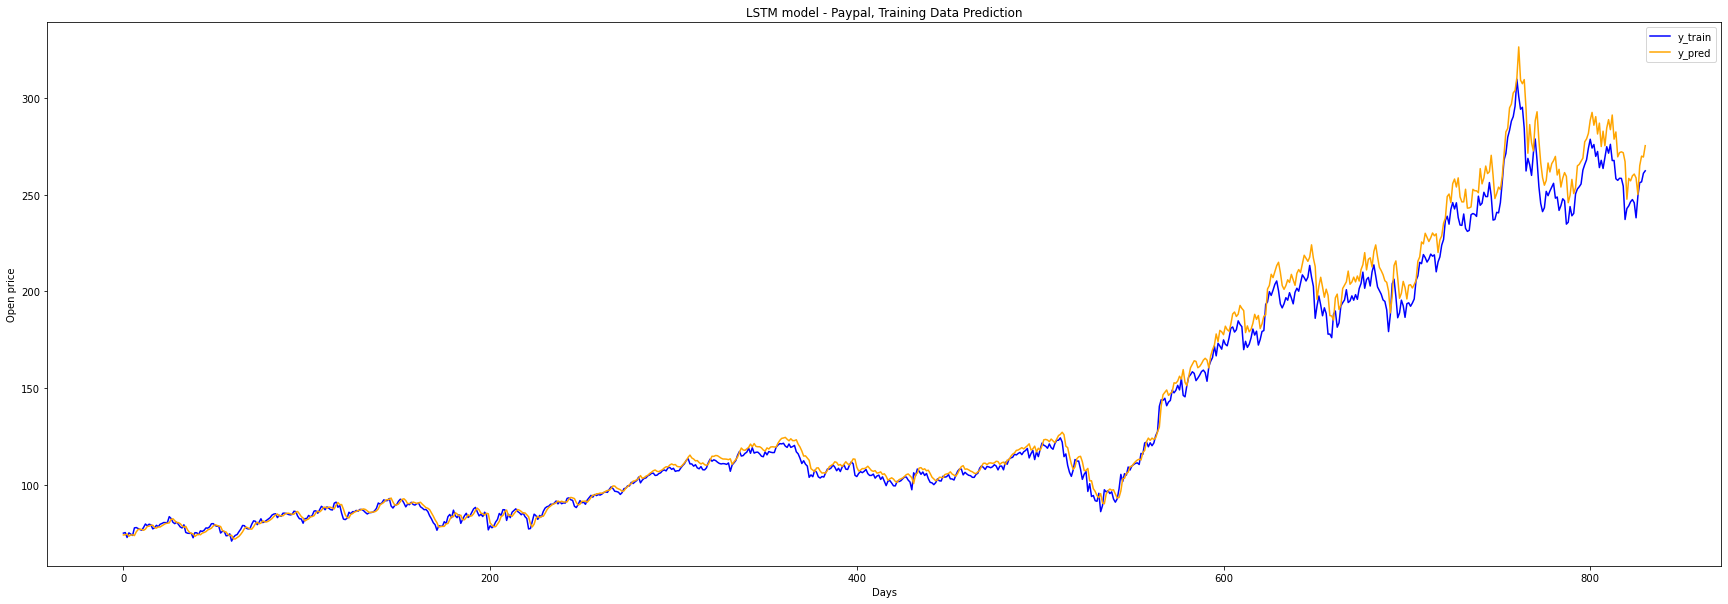

11/11 [==============================] - 0s 11ms/step


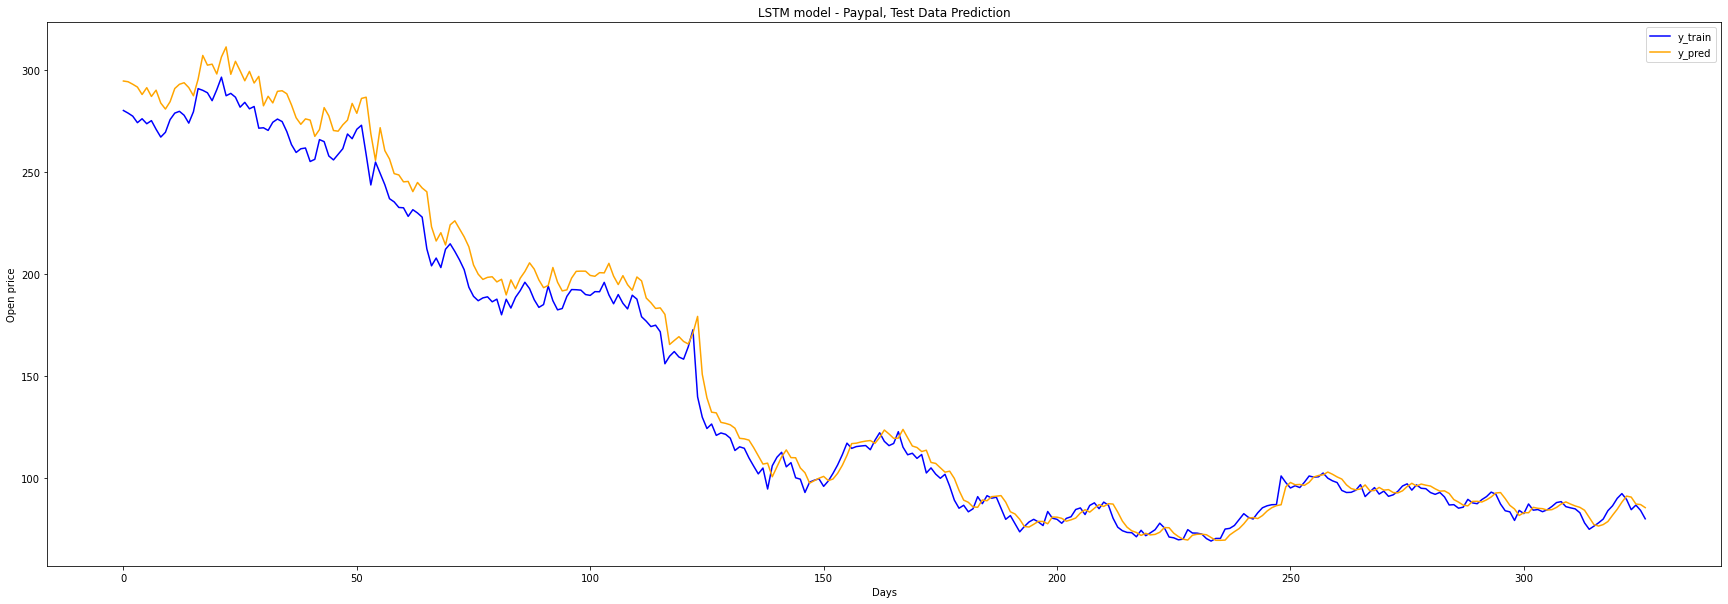

(50, 97.0962896238147, 174.0596438936734, 49.37983007054492, 90.54462531156997)


In [9]:
output = train('Paypal', df_paypal, 0.7, 50)
print(output)

Training on Paypal stock data
Original length:  1258
Train length:  881
Valid length:  377


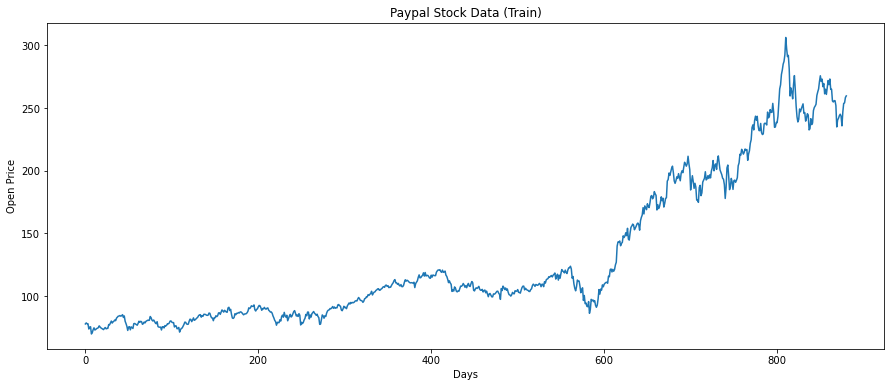

Shape of X_train:  (821, 60, 1)
Shape of y_train:  (821, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 60, 50)            2600      
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 60, 50)            5050      
                                       

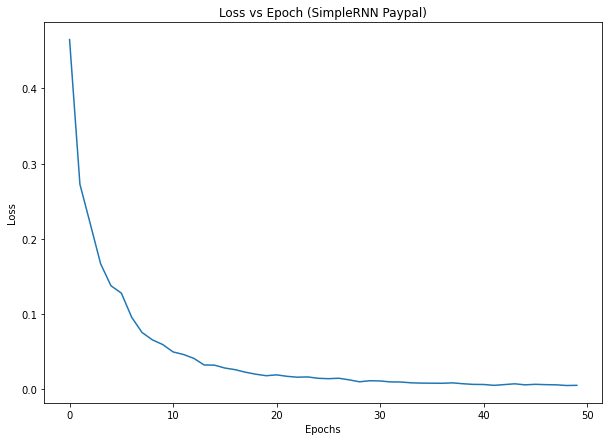

26/26 [==============================] - 1s 18ms/step


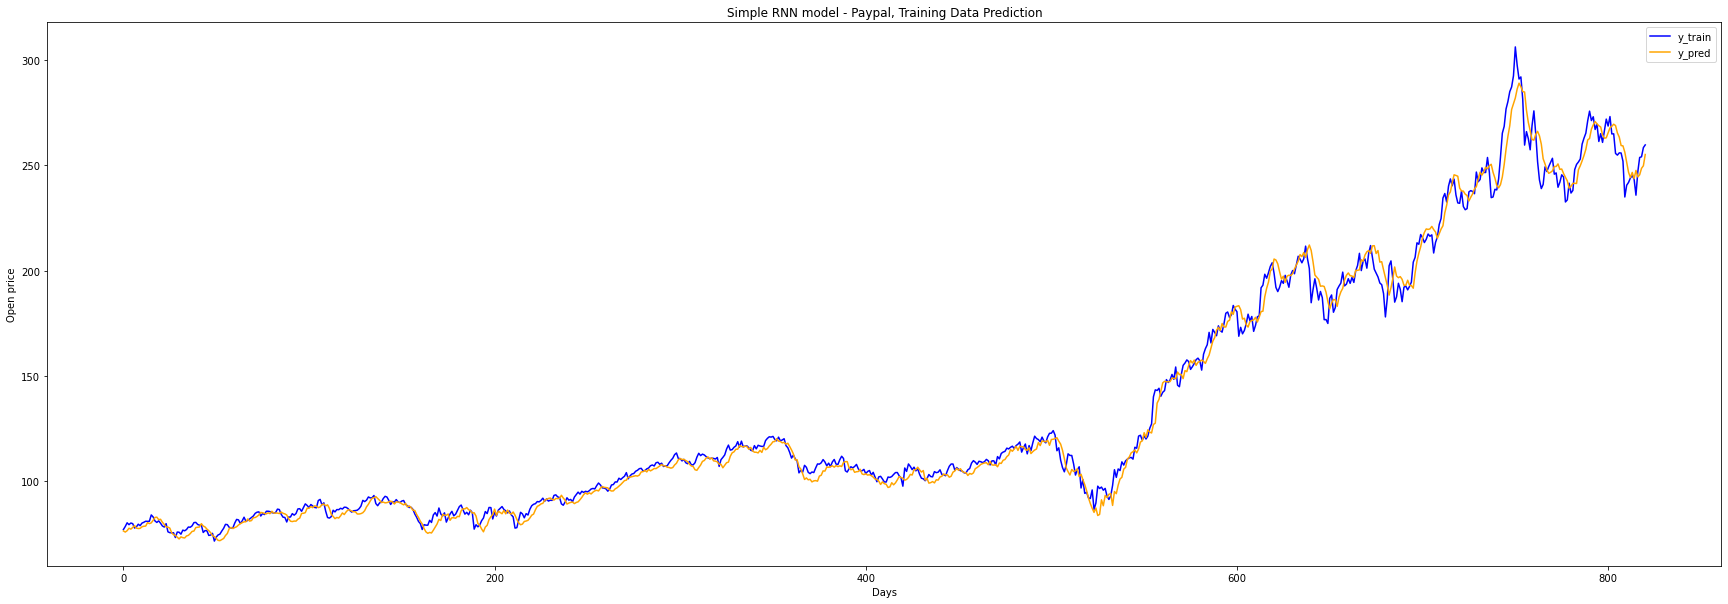

Shape of X_test:  (327, 50, 1)
Shape of y_test:  (327, 1)
11/11 [==============================] - 1s 13ms/step


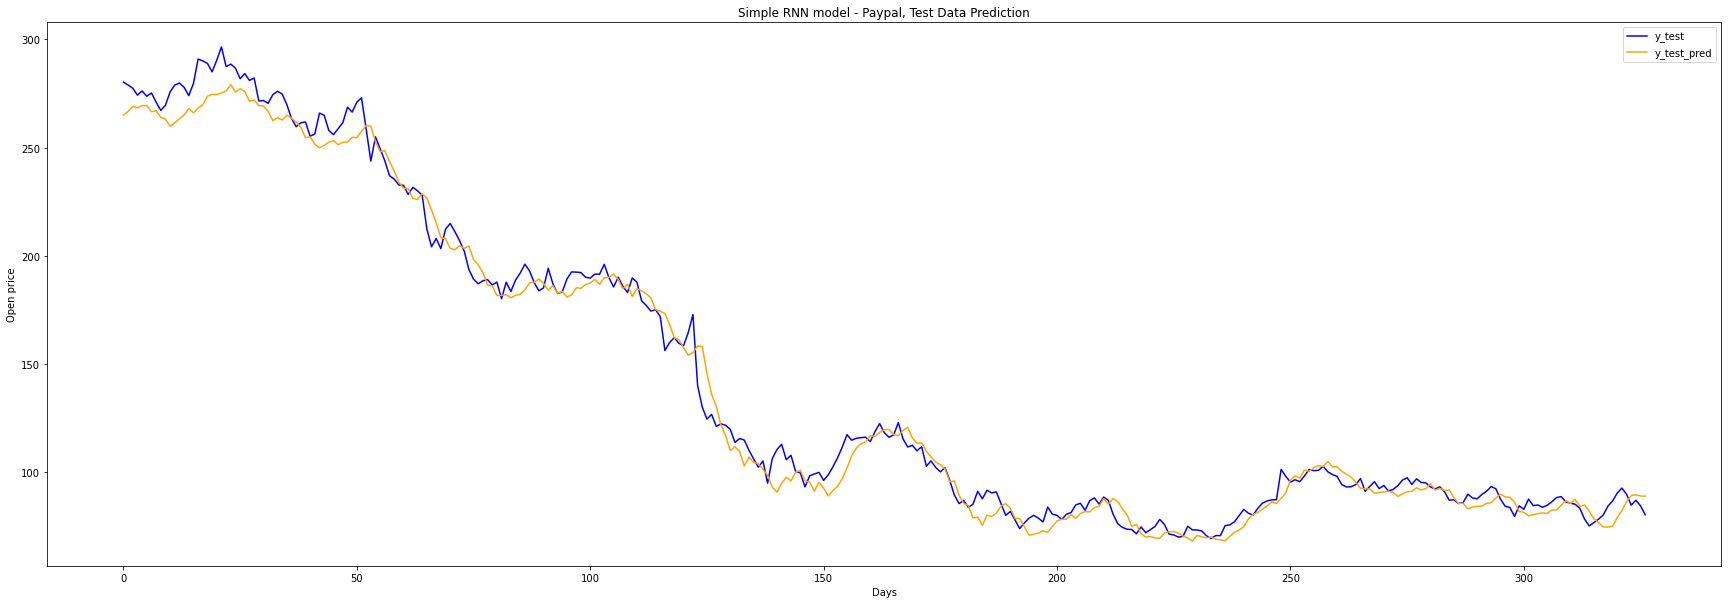

Model: "LSTM-Paypal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________
None

Training LSTM model on Paypal data
Epoch 1/50
83/83 [==============================] - 10s 33ms/step - loss: 0.0076
Epoch 2/50
83/83 [==============================] - 3s 35ms/s

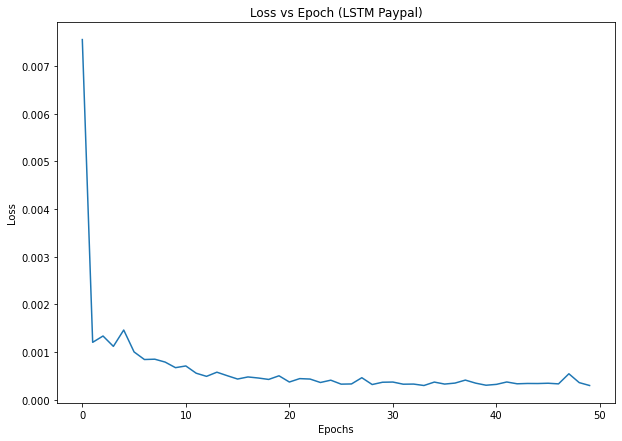

26/26 [==============================] - 2s 20ms/step


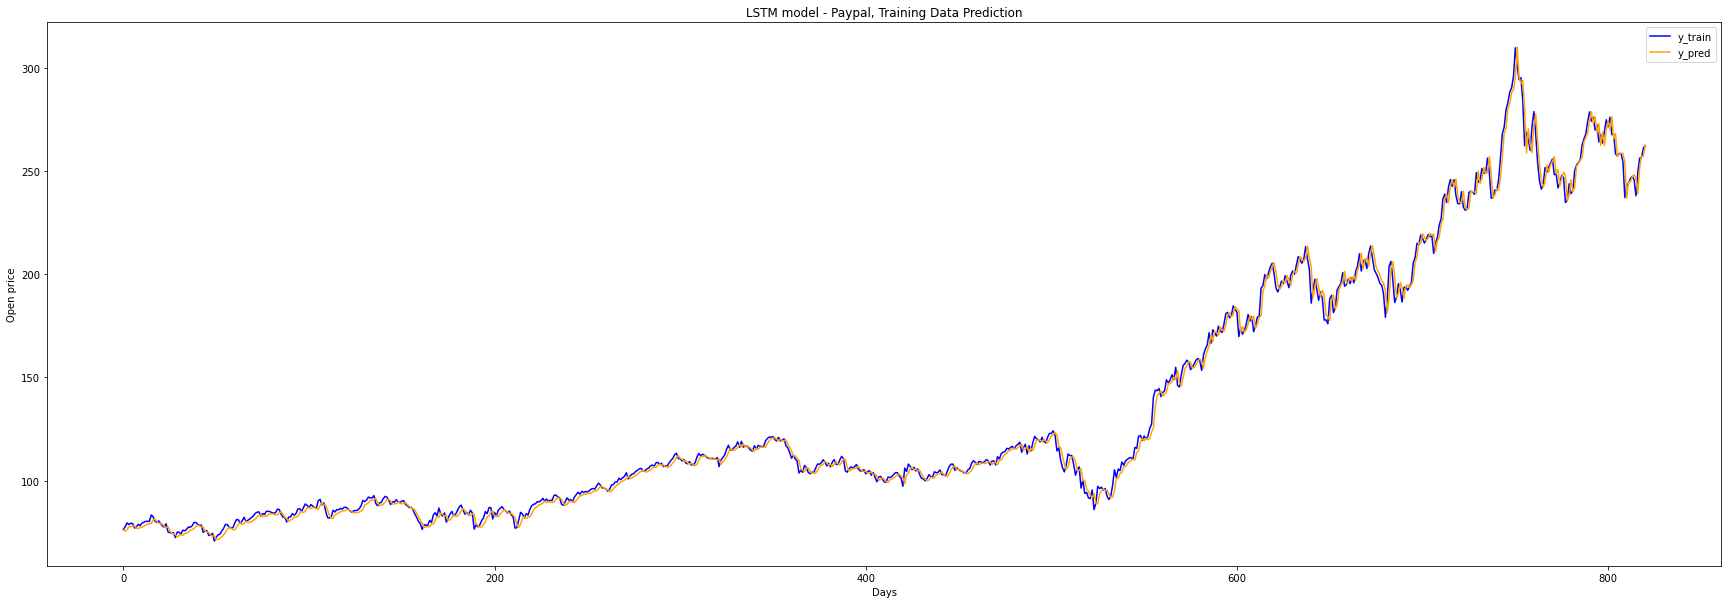

11/11 [==============================] - 2s 15ms/step


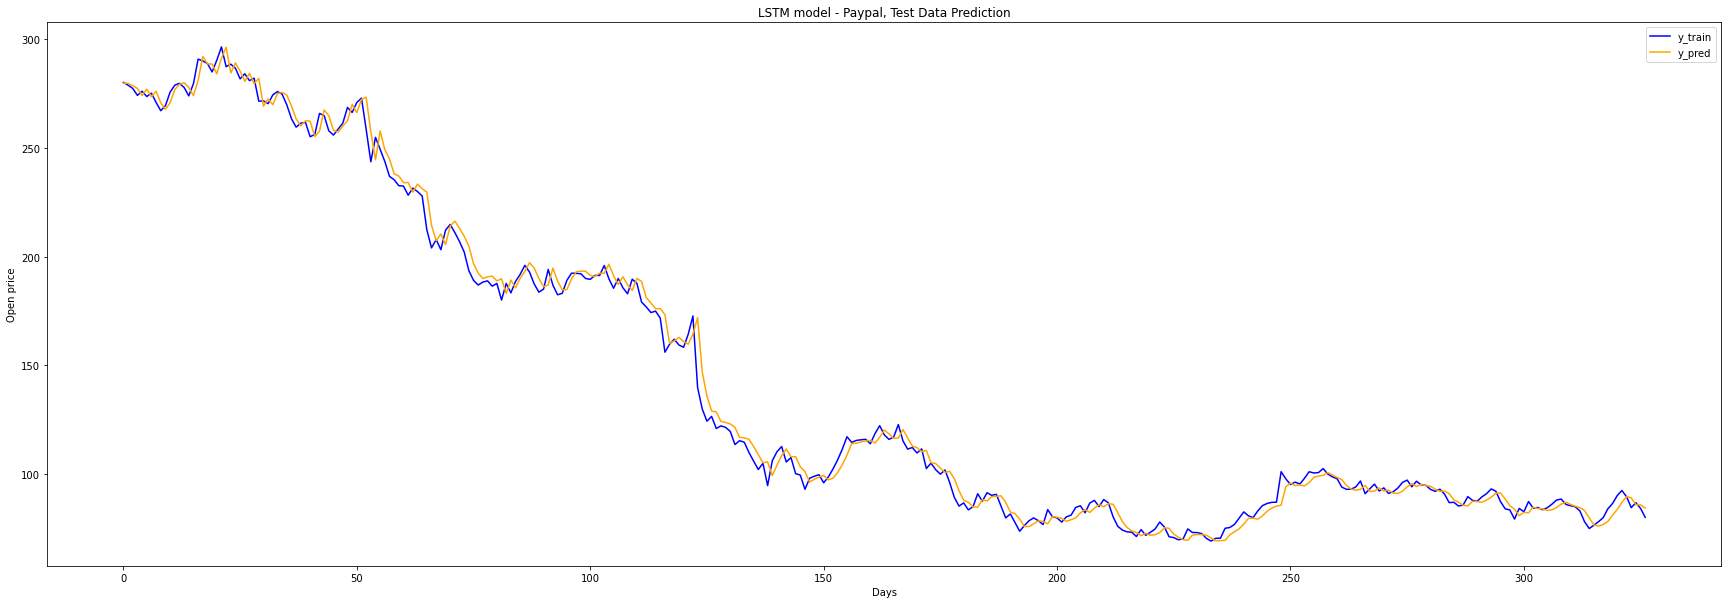

(60, 28.161751595471788, 56.53387163998477, 13.792010127505625, 24.770144384429102)


In [10]:
output = train('Paypal', df_paypal, 0.7, 60)
print(output)